In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, cv2
import PIL
%matplotlib inline

### Using a Neural Network

In [2]:
training_data = datasets.FashionMNIST(root="../../datasets/Datasets/FashinMNIST/", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="../../datasets/Datasets/FashinMNIST/", train=False, download=True, transform=ToTensor())

In [3]:
bacth_size = 64

train_dataloader = DataLoader(training_data, batch_size=bacth_size)
test_dataloader = DataLoader(test_data, batch_size=bacth_size)

for X,y in test_dataloader:
    print(f"Shape of Training Images: [N, C, H, W]: {X.shape}")
    print(f"Shape of Training Labels: [y]: {y.shape} {y.dtype}")
    break

Shape of Training Images: [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of Training Labels: [y]: torch.Size([64]) torch.int64


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using cpu
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%100==0:
            loss, current = loss.item(), batch*len(X)
            print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {100*correct:>0.1f}%, Avg Loss: {test_loss:>8f} \n")

In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done..!")

Epoch 1
---------------------------------------
Loss: 2.302726 [    0/60000]
Loss: 2.302453 [ 6400/60000]
Loss: 2.302516 [12800/60000]
Loss: 2.302180 [19200/60000]
Loss: 2.301488 [25600/60000]
Loss: 2.302208 [32000/60000]
Loss: 2.301138 [38400/60000]
Loss: 2.300889 [44800/60000]
Loss: 2.302280 [51200/60000]
Loss: 2.301029 [57600/60000]
Test Error: 
 Accuracy: 19.0%, Avg Loss: 2.301170 

Epoch 2
---------------------------------------
Loss: 2.301444 [    0/60000]
Loss: 2.301219 [ 6400/60000]
Loss: 2.301034 [12800/60000]
Loss: 2.301037 [19200/60000]
Loss: 2.300129 [25600/60000]
Loss: 2.300610 [32000/60000]
Loss: 2.299980 [38400/60000]
Loss: 2.299441 [44800/60000]
Loss: 2.301043 [51200/60000]
Loss: 2.299663 [57600/60000]
Test Error: 
 Accuracy: 28.9%, Avg Loss: 2.299791 

Epoch 3
---------------------------------------
Loss: 2.300158 [    0/60000]
Loss: 2.299975 [ 6400/60000]
Loss: 2.299532 [12800/60000]
Loss: 2.299861 [19200/60000]
Loss: 2.298727 [25600/60000]
Loss: 2.298967 [32000/60000

In [7]:
torch.save(model.state_dict(), "./weights/my_first_model_FashinMNIST_NN.pth")
print("Saved PyTorch Model State")

Saved PyTorch Model State


In [8]:
model = NeuralNetwork()
model.load_state_dict(torch.load("./weights/my_first_model_FashinMNIST_NN.pth"))

<All keys matched successfully>

9
tensor([[0.0918, 0.0890, 0.1033, 0.0875, 0.0942, 0.0873, 0.0907, 0.1076, 0.1175,
         0.1311]])
Predicted: Ankle boot, Actual: Ankle boot


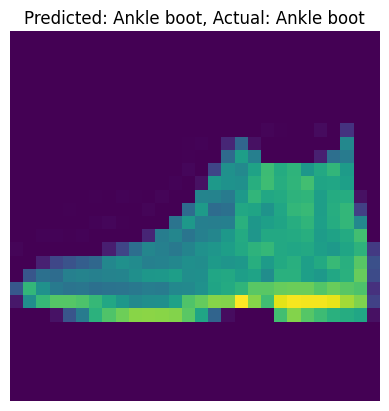

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x,y = test_data[0][0], test_data[0][1]
print(y)
with torch.no_grad():
    pred = model(x)
    print(pred)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: {predicted}, Actual: {actual}")
    image = x.numpy()
    image = image.reshape([image.shape[1], image.shape[2]])
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted}, Actual: {actual}")
    plt.show()